In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
input_data = 'final_result.json'

In [3]:
with open(input_data) as f:
    data = json.loads(f.read())

In [4]:
# clean and add necessary data fields
for payload_size in data:
#     print(f'Input payload size: {payload_size}KB')
    data[payload_size]['get_checkpoint'] = np.array(data[payload_size]['get_checkpoint'])
    data[payload_size]['egress total'] = np.array(data[payload_size]['egress total'])
    data[payload_size]['run_checkpoint'] = np.array(data[payload_size]['run_checkpoint'])
    data[payload_size]['run_continuation'] = np.array(data[payload_size]['run_continuation'])
    data[payload_size]['user function'] = np.array(data[payload_size]['user function'])
    data[payload_size]['invoke'] = np.array(data[payload_size]['invoke'])
    data[payload_size]['checkpoint read'] = np.array(data[payload_size]['checkpoint read'])
    data[payload_size]['checkpoint write'] = np.array(data[payload_size]['checkpoint write'])

    # total additional latency is get_checkpoint() + egress total
    # This is the total latency in addition to user functions that unum runtime incurs
    # This latency number translates directly to costs and should be compared with Step Functions costs
    data[payload_size]['total additional'] = data[payload_size]['get_checkpoint'] + data[payload_size]['egress total']
    
    # total checkpoint related latency: get_checkpoint() + run_checkpoint()
    data[payload_size]['checkpoint total'] = data[payload_size]['get_checkpoint'] + data[payload_size]['run_checkpoint']
    
    # invoke + checkpoint read + checkpoint write
    data[payload_size]['2s1i'] = data[payload_size]['invoke'] + data[payload_size]['checkpoint read'] + data[payload_size]['checkpoint write']

In [5]:
''' aggregate computes the mean and std for each component steps:
    1. get_checkpoint 
    2. run_checkpoint
    3. run_continuation
    4. egress total
    5. user function
    
    Additionally, aggregates also computes the mean and std for
    1. total additional: total additional latency, which is get_checkpoint() + egress total
    2. checkpoint total: get_checkpoint() + run_checkpoint()
'''


aggregate = {}
for payload_size in data:
    aggregate[payload_size] = {
        # each key is mapped to a list whose 0th element is mean and 1st element is std
        "get_checkpoint": [np.mean(data[payload_size]["get_checkpoint"]), np.std(data[payload_size]["get_checkpoint"])],
        "run_checkpoint": [np.mean(data[payload_size]["run_checkpoint"]), np.std(data[payload_size]["run_checkpoint"])],
        "run_continuation": [np.mean(data[payload_size]["run_continuation"]), np.std(data[payload_size]["run_continuation"])],
        "egress total": [np.mean(data[payload_size]["egress total"]), np.std(data[payload_size]["egress total"])],
        "user function": [np.mean(data[payload_size]["user function"]), np.std(data[payload_size]["user function"])],
        "total additional": [np.mean(data[payload_size]["total additional"]), np.std(data[payload_size]["total additional"])],
        "total additional 99p": [np.percentile(data[payload_size]["total additional"], 99)],
        "checkpoint total": [np.mean(data[payload_size]["checkpoint total"]), np.std(data[payload_size]["checkpoint total"])],
        "checkpoint total 99p": [np.percentile(data[payload_size]["checkpoint total"], 99)],
        "invoke 50p": [np.percentile(data[payload_size]["invoke"], 50)],
#         "invoke 99p": [np.percentile(data[payload_size]["invoke"], 99)],
        "checkpoint read 50p": [np.percentile(data[payload_size]["checkpoint read"], 50)],
        "checkpoint write 50p": [np.percentile(data[payload_size]["checkpoint write"], 50)],
        "2s1i 50p": [np.mean(data[payload_size]["2s1i"])],
        "invoke pct" : [np.mean(data[payload_size]["invoke"])/np.mean(data[payload_size]["total additional"])*100],
        "read checkpoint pct" : [np.mean(data[payload_size]["checkpoint read"])/np.mean(data[payload_size]["total additional"])*100],
        "write checkpoint pct" : [np.mean(data[payload_size]["checkpoint write"])/np.mean(data[payload_size]["total additional"])*100]
    }
    
    aggregate[payload_size]["2s1i pct"] = [min(99.8,aggregate[payload_size]["invoke pct"][0] + aggregate[payload_size]["read checkpoint pct"][0] + aggregate[payload_size]["write checkpoint pct"][0])]



In [6]:
aggregate

{'0': {'get_checkpoint': [8.827158937499998, 3.8825260531779997],
  'run_checkpoint': [21.4312184375, 2.495524214101718],
  'run_continuation': [43.258318125, 10.188874536757254],
  'egress total': [64.965106625, 9.678908668277609],
  'user function': [0.0013571500000000001, 0.0002474904594120751],
  'total additional': [73.7922655625, 11.055008130702678],
  'total additional 99p': [100.70900179999998],
  'checkpoint total': [30.258377375, 4.680896670302041],
  'checkpoint total 99p': [40.5098038],
  'invoke 50p': [39.857580999999996],
  'checkpoint read 50p': [6.603317],
  'checkpoint write 50p': [20.0632575],
  '2s1i 50p': [73.3417003125],
  'invoke pct': [58.54583240625517],
  'read checkpoint pct': [11.855444548711338],
  'write checkpoint pct': [28.98813703501543],
  '2s1i pct': [99.38941398998193]},
 '5': {'get_checkpoint': [11.1776311875, 4.587233363422503],
  'run_checkpoint': [22.8449388125, 4.622438815546875],
  'run_continuation': [45.37184175, 5.6813165688561735],
  'egress

In [7]:
# plot each component operation vs input payload size
# plot the total additional vs input payload size
# plot the checkpoint total vs input payload size

payload_sizes = list(aggregate.keys())

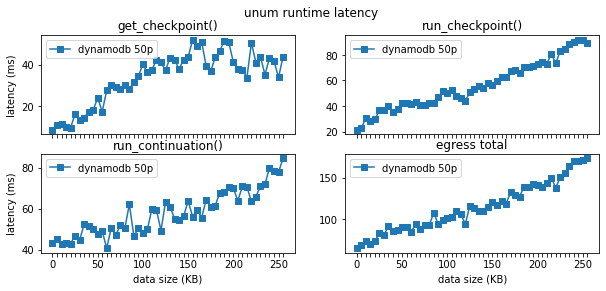

In [8]:
# plot each component operation vs input payload size

# Example:
# get_checkpoint_mean = [aggregate[s]['get_checkpoint'][0] for s in aggregate]
# get_checkpoint_std = [aggregate[s]['get_checkpoint'][1] for s in aggregate]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,4))
fig.suptitle('unum runtime latency')

# get_checkpoint
ax1.plot(payload_sizes, [aggregate[s]['get_checkpoint'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax1.set_title('get_checkpoint()')
ax1.set(ylabel='latency (ms)')
ax1.legend()
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# run_checkpoint
ax2.plot(payload_sizes, [aggregate[s]['run_checkpoint'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax2.set_title('run_checkpoint()')
ax2.legend()
for label in ax2.xaxis.get_ticklabels():
    label.set_visible(False)
# run_continuation
ax3.plot(payload_sizes, [aggregate[s]['run_continuation'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax3.set_title('run_continuation()')
ax3.set(xlabel='data size (KB)', ylabel='latency (ms)')
ax3.legend()
for idx, label in enumerate(ax3.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)
# egress total
ax4.plot(payload_sizes, [aggregate[s]['egress total'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax4.set_title('egress total')
ax4.set(xlabel='data size (KB)')
ax4.legend()
for idx, label in enumerate(ax4.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)

fig.savefig('OpLatency.pdf', format='pdf')

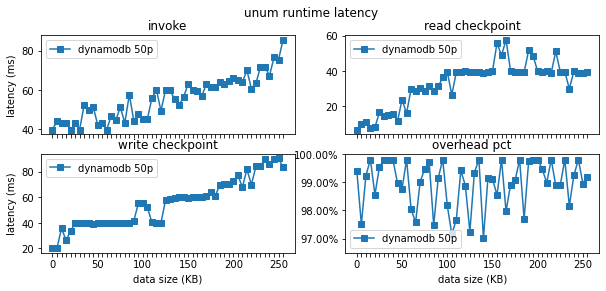

In [9]:
# plot each component operation vs input payload size

# Example:
# get_checkpoint_mean = [aggregate[s]['get_checkpoint'][0] for s in aggregate]
# get_checkpoint_std = [aggregate[s]['get_checkpoint'][1] for s in aggregate]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,4))
fig.suptitle('unum runtime latency')

# get_checkpoint
ax1.plot(payload_sizes, [aggregate[s]['invoke 50p'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax1.set_title('invoke')
ax1.set(ylabel='latency (ms)')
ax1.legend()
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# run_checkpoint
ax2.plot(payload_sizes, [aggregate[s]['checkpoint read 50p'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax2.set_title('read checkpoint')
ax2.legend()
for label in ax2.xaxis.get_ticklabels():
    label.set_visible(False)
# run_continuation
ax3.plot(payload_sizes, [aggregate[s]['checkpoint write 50p'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax3.set_title('write checkpoint')
ax3.set(xlabel='data size (KB)', ylabel='latency (ms)')
ax3.legend()
for idx, label in enumerate(ax3.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)

# invoke + read checkpoint + write checkpoint as a percentage of total additional


        
ax4.plot(payload_sizes, [aggregate[s]['2s1i pct'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax4.set_title('overhead pct')
ax4.set(xlabel='data size (KB)')
ax4.set_ylim(96.5, 100)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter())
ax4.legend()
for idx, label in enumerate(ax4.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)

fig.savefig('OpLatency.pdf', format='pdf')

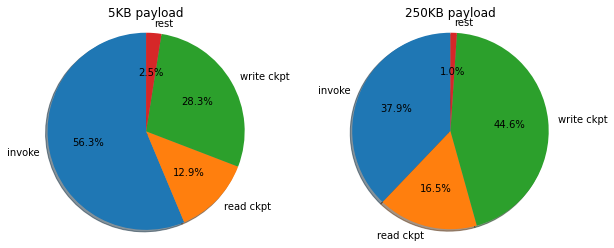

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))


labels = 'invoke', 'read ckpt', 'write ckpt', 'rest'
five_kb = [aggregate["5"]['invoke pct'][0]/100,aggregate["5"]['read checkpoint pct'][0]/100,aggregate["5"]['write checkpoint pct'][0]/100, 1-(aggregate["5"]['invoke pct'][0]+aggregate["5"]['read checkpoint pct'][0]+aggregate["5"]['write checkpoint pct'][0])/100]
# explode = (0, 0.0, 0, 0)
ax1.set_title('5KB payload')
ax1.pie(five_kb, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

two_fifty_kb = [aggregate["250"]['invoke pct'][0]/100,aggregate["250"]['read checkpoint pct'][0]/100,aggregate["250"]['write checkpoint pct'][0]/100, 1-(aggregate["250"]['invoke pct'][0]+aggregate["250"]['read checkpoint pct'][0]+aggregate["250"]['write checkpoint pct'][0])/100]
# explode = (0, 0.0, 0, 0)

ax2.pie(two_fifty_kb, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('250KB payload')
fig.savefig('OpLatency-pct.pdf', format='pdf')

(0.126, 0.5775)

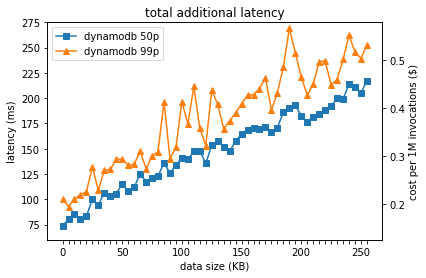

In [11]:
# plot the total additional vs input payload size
# Lambda's duration costs is $0.0021 per 1,000,000ms-128MB for us-west-1
# there's a $0.2 per 1,000,000 requests fee but this is the same no matter
# what workflow systems you use (step functions or unum)
# Step Functions charges a $27.9 per 1,000,000 state transitions

fig, ax = plt.subplots()
price_ax=ax.twinx()

# ylim for the latency
# the ylim for price is latency * 0.0021
ylim_top = 275
ylim_bottom = 60

ax.plot(payload_sizes, [aggregate[s]['total additional'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax.plot(payload_sizes, [aggregate[s]['total additional 99p'][0] for s in aggregate], marker='^', label='dynamodb 99p')
ax.set_title('total additional latency')
ax.set(xlabel='data size (KB)',ylabel='latency (ms)')
ax.set_ylim(ylim_bottom, ylim_top)
ax.legend()
for idx, label in enumerate(ax.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)

price_ax.set_ylabel('cost per 1M invocations ($)')
price_ax.set_ylim(ylim_bottom*0.0021, ylim_top*0.0021)

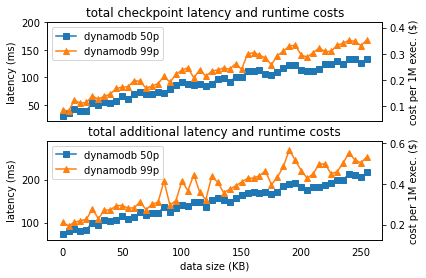

In [12]:
# plot the checkpoint total vs input payload size
fig, (ax1, ax2) = plt.subplots(2)

price_ax1=ax1.twinx()

# ylim for the latency
# the ylim for price is latency * 0.0021
ylim_top = 200
ylim_bottom = 20

ax1.plot(payload_sizes, [aggregate[s]['checkpoint total'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax1.plot(payload_sizes, [aggregate[s]['checkpoint total 99p'][0] for s in aggregate], marker='^', label='dynamodb 99p')
ax1.set_title('total checkpoint latency and runtime costs')
ax1.set(ylabel='latency (ms)')
ax1.set_ylim(ylim_bottom, ylim_top)
ax1.legend()

price_ax1.set_ylabel('cost per 1M exec. ($)')
price_ax1.set_ylim(ylim_bottom*0.0021, ylim_top*0.0021)

for label in ax1.xaxis.get_ticklabels():
    label.set_visible(False)
    
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

#
price_ax2=ax2.twinx()

# ylim for the latency
# the ylim for price is latency * 0.0021
ylim_top = 290
ylim_bottom = 60      
ax2.plot(payload_sizes, [aggregate[s]['total additional'][0] for s in aggregate], marker='s', label='dynamodb 50p')
ax2.plot(payload_sizes, [aggregate[s]['total additional 99p'][0] for s in aggregate], marker='^', label='dynamodb 99p')
ax2.set_title('total additional latency and runtime costs')
ax2.set(xlabel='data size (KB)',ylabel='latency (ms)')
ax2.set_ylim(ylim_bottom, ylim_top)
ax2.legend()

ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

for idx, label in enumerate(ax2.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)

price_ax2.set_ylabel('cost per 1M exec. ($)')
price_ax2.set_ylim(ylim_bottom*0.0021, ylim_top*0.0021)

fig.savefig('TotalAdditionalLatency.pdf', format='pdf')

In [13]:
print(max([aggregate[s]['total additional'][0] for s in aggregate])*0.0021)
print(max([aggregate[s]['total additional 99p'][0] for s in aggregate])*0.0021)

0.4558821626625
0.56519634801


As there is no way for us to accurately measure the amount of resources consumed directly, we use dollar costs as a proxy to the resource costs of running the workflows. This is not a perfect proxy as many other factors go into deciding the pricing. But assuming that the cloud providers are not stupid, we believe this is a reasonable proxy to the resources costs of running the workflows.

We can see that the runtime latency costs is negligible. Even if we increase the Lambda size to 1GB, the cost would still be $0.0167 per 1,000,000ms-1GB instead of $0.0021. which means $0.5 becomes $5, which is still way cheaper than $28.

This tells us that we can basically ignore the runtime latency costs of unum.

The cost of checkpointing thus largely depends on the pricing of the data store.

DynamoDB charges based on the size of the object written in on-demand mode: $1.3942 per million write request units (which is 1KB). This is very expensive. It means at the 256KB, 1M checkpoints = 256 x $1.3942 =  $356.9152.

S3 on the other hand, only charges by the number of requests and not by the item size: $5.5 per 1M PUT requests.

We don't need to take into account of storing costs because that's negligible for both s3 and dynamodb. Also, these intermediary data can be deleted immediately after workflow execution unless for future audits.



So on a high level, I can't say that using unum is always cheaper because DynamoDB can cost a lot. 

I also can't say that 5KB is the typical payload size, because I don't know.

But I do know that S3 is available and that's a lot cheaper. So maybe I should also present the S3 numbers.

    If I do, then for each graph, have 4 lines: dynamodb 50p dynamodb 99p, s3 50p and s3 99p
    
    Then plot the total costs vs input payload size or output size. Have 2 curves, one for s3, and one for dynamodb
    
Regardless, I should discuss the costs of checkpointing separating from the costs of running the unum code in Lambda. Presenting s3 number is good because it should an option if you want the cheapest that still works.


We also want to compare latency performance of basic building block orchestration patterns such as chaining.

We really want to compare the latency difference between unum's invoking a continuation and Step Functions' transitioning into a state. However, the comparison wouldn't be apple-to-apple because I cannot separate in the Step Functions' log how long it takes the Step Functions to receive data from Lambda, how long it takes to checkpoint, how long it takes to transition to the next state, and how long it takes to actually invoking the next Lambda. It's all lumped together.
Therefore, it might be a better to compare e2e performance of F->G and F->G->H->.... where each Lambda does minimum work (1-2ms) such that the majority of the latency comes from the workflow system (i.e., unum runtime and Step Functions state machine)

Similarly for fan-out and fan-in, e2e latency is a better comparison.


# Comparing the latency of a state transition in unum and in step functions

A state transition is A->B. It involves persisting A's results and invoking an instance of B.


In [40]:
# unum

# done above


# Step Function
sf_input_data = '../step-functions/final_result.json'
with open(sf_input_data) as f:
    sf_data = json.loads(f.read())
    
sf_aggregate = {
    'success to start 50p':[],
    'success to start 99p':[],
    'success to scheduled 50p':[],
    'success to scheduled 99p':[],
}
for payload_size in data:
    sf_aggregate['success to start 50p'].append(np.percentile(sf_data[payload_size]['success to start'],50))
    sf_aggregate['success to start 99p'].append(np.percentile(sf_data[payload_size]['success to start'], 80))
    sf_aggregate['success to scheduled 50p'].append(np.percentile(sf_data[payload_size]['success to scheduled'],50))
    sf_aggregate['success to scheduled 99p'].append(np.percentile(sf_data[payload_size]['success to scheduled'], 80))

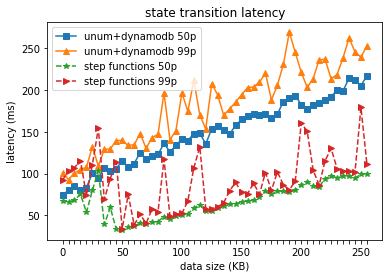

In [41]:
# plot the total additional vs input payload size
# Lambda's duration costs is $0.0021 per 1,000,000ms-128MB for us-west-1
# there's a $0.2 per 1,000,000 requests fee but this is the same no matter
# what workflow systems you use (step functions or unum)
# Step Functions charges a $27.9 per 1,000,000 state transitions

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
fig, ax1 = plt.subplots()

ax1.plot(payload_sizes, [aggregate[s]['total additional'][0] for s in aggregate], marker='s', label='unum+dynamodb 50p')
ax1.plot(payload_sizes, [aggregate[s]['total additional 99p'][0] for s in aggregate], marker='^', label='unum+dynamodb 99p')

ax1.plot(payload_sizes, sf_aggregate['success to start 50p'] , marker='*', ls='--', label='step functions 50p')
ax1.plot(payload_sizes, sf_aggregate['success to start 99p'] , marker='>', ls='--', label='step functions 99p')

ax1.set_title('state transition latency')
ax1.set(xlabel='data size (KB)',ylabel='latency (ms)')

ax1.legend()
for idx, label in enumerate(ax1.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)

        
ax2.plot(payload_sizes, [aggregate[s]['total additional'][0] for s in aggregate], marker='s', label='unum+dynamodb 50p')
ax2.plot(payload_sizes, sf_aggregate['success to start 50p'] , marker='*', ls='--', label='step functions 50p')

ax2.set_title('state transition latency')
ax2.set(xlabel='data size (KB)',ylabel='latency (ms)')

ax2.legend()
for idx, label in enumerate(ax2.xaxis.get_ticklabels()):
    if int(payload_sizes[idx]) % 50 != 0:
        label.set_visible(False)
        
fig.savefig('TotalAdditionalLatency.pdf', format='pdf')

# Cost analysis

In [56]:
data_sizes = np.array([e for e in range(0,260,5)])

In [57]:
unum_dynamodb_average_runtime_overhead = np.array([aggregate[s]['total additional'][0] for s in aggregate])

unum_dynamodb_cost = unum_dynamodb_average_runtime_overhead*0.05 + data_sizes*1.3942 + 0.279

In [87]:
# unum_s3_average_runtime_overhead = np.array([aggregate[s]['total additional'][0]for s in aggregate])

# unum_s3_cost = unum_s3_average_runtime_overhead*0.05 + 5.94

In [88]:
step_functions_costs = np.array([27.8 for _ in range(0,260,5)])

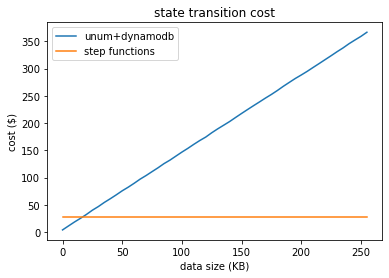

In [91]:
fig, ax1 = plt.subplots()

ax1.plot(data_sizes, unum_dynamodb_cost, label='unum+dynamodb')
# ax1.plot(data_sizes, unum_s3_cost, label='unum+s3')
ax1.plot(data_sizes, step_functions_costs, label='step functions')
ax1.set_title('state transition cost')
ax1.set(xlabel='data size (KB)',ylabel='cost ($)')

ax1.legend()
fig.savefig('TotalCost.pdf', format='pdf')